# DBLP Dataset
Download the data from https://www.kaggle.com/datasets/mathurinache/citation-network-dataset, unzip it, and store it as `dblp.v12.json` in this directory.

### Transform the data for use with the sampling pipeline

For testing, we will use a sample of the full dataset, which we can create by running the following commands in this directory:
```
head -1000000 dblp.v12.json > dblp.v12.1M.json
echo ] >> dblp.v12.1M.json
```
It is important here to take a large sample from the full dataset, to make sure that we have at least some edges for which we know both the source **and** the target data to work with.

Since the data is nested -- which does not work nicely with pandas -- we read it with the stdlib `json` module first, extracting nodes and edges. This took around 15 minutes on our hardware.

In [20]:
import json
import pandas as pd

edges = []
nodes = []

with open("./dblp.v12.1M.json", encoding='Latin1') as json_file:
  data = json.load(json_file)

  for row in data:
    node = {
      "id": row["id"],
      "n_citation": row["n_citation"],
      "title": row["title"],
      "year": row["year"]
    }
    nodes += [node]

    if "references" not in row:
      continue
    
    for reference in row["references"]:
      edges += [[node["id"], reference]]

edges_df = pd.DataFrame(edges, columns=["source", "target"])
nodes_df = pd.DataFrame(nodes).set_index("id")

For convenience, we store nodes and edges as CSV files, only keeping those edges for which we also have source and target nodes in the sample. 
Then, once we have run this cell, we no longer need to go through the lengthy conversion above when working with the data, since we can just load the CSV files.

In [21]:
exists = ~edges_df.join(nodes_df, on="target")["year"].isnull()
edges_df[exists].to_csv("dblp_edges.1M.csv", sep=";", index=False)
nodes_df.to_csv("dblp_nodes.1M.csv", sep=";", index=True)  # make sure that id is stored!

Create a joined table that contains all information for both source and target.
Of course, this means that there are duplicates, but as proof-of-concept, we include those data.

In [53]:
import pandas as pd

edges_df = pd.read_csv("dblp_edges.1M.csv", delimiter=";")
nodes_df = pd.read_csv("dblp_nodes.1M.csv", delimiter=";", index_col="id")

edges_df.join(nodes_df, on="source", lsuffix="source").join(nodes_df, on="target", lsuffix="_source", rsuffix="_target").to_csv("dblpData.csv", sep=";", header=False, index=True, index_label="index")

columns = ["source", "target", "n_citation_source", "title_source", "year_source", "n_citation_target", "title_target", "year_target"]

### Plot the network

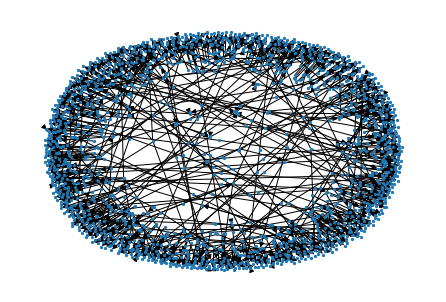

In [55]:
import networkx as nx
import pandas as pd

# data can be downloaded from http://nrvis.com/download/data/cit/cit-DBLP.zip
# and it only contains the edges of the graph

df = pd.read_csv("dblpData.csv", delimiter=";", names=["index", "source", "target", "n_citation_source", "title_source", "year_source", "n_citation_target", "title_target", "year_target"], index_col="index")
# nx.draw takes a very long time on the entire dataset, so we use a sample instead.
G = nx.from_pandas_edgelist(df[["source", "target"]].loc[:1000])

G_ = nx.DiGraph(G.edges)
nx.draw(G_, pos=nx.spring_layout(G_), node_size=5)

### Plot the distribution of citations

<AxesSubplot:ylabel='Frequency'>

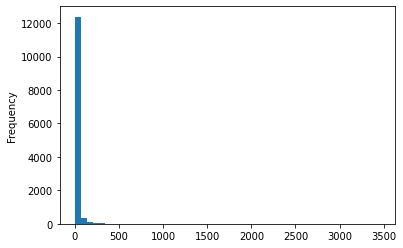

In [65]:
import pandas as pd

df = pd.read_csv("dblpData.csv", delimiter=";", names=["index", "source", "target", "n_citation_source", "title_source", "year_source", "n_citation_target", "title_target", "year_target"], index_col="index")

df["n_citation_source"].plot.hist(bins=50)

In [ ]:
import os, sys
sys.path.append(f"{os.getcwd()}/../")

import pandas as pd
import numpy as np
import networkx as nx

from GraphLinearizations import BasicGraphLinearization


lin = BasicGraphLinearization("dblp", dimensions=9, exclude_attributes=[])

lin.read_data()
np.array(lin.linearize())